# From game theory to general information seeking

## Intro

Minimax assumes the worst case scenario, where the opponent is optimal. This simplifies search to a single worst case scenario world model, but can miss rewards when facing weaker opponents (e.g., via traps).

If one were to know with certainty the model of the opponent (and that opponent model of oneself), that could be used to model adversary choices via a recursive minimax search. The simplest cases involve:

1. `X` assumes `O` plays randomly, in which case the evaluation converges to a simple dynamic programming search (or expectiminimax without adversary nodes).

2. `X` knows that `O` assumes `X` plays randomly, in which case `X` can simulate how `O` would evaluate each position and play against that. This allows for deterministic traps. It assumes `O` would never realize `X` is not actually playing at random.

Curiosity question: If both assume the other assumes each one plays randomly, it would converge back to the original minimax?

3. `X` knows that `O` uses a given heuristic instead of recursive minimax search (mixed models where an adversary may use minimax for `n` iterations followed by heuristic evaluation can also be considered)

In each case it should be possible (provided the game is flexible enoguh) for `X` to increase it's expected payoff by deviating from the optimal policy, specially in cases where it starts at a disadvantage.

**Section 1** provides simple demos for these 3 scenarios, with references to more extensive works that have been published in the literature.

***

**Section 2** exhamines more complicated scenarios, where `X` does not know for sure what the model of `O` is, but might be able to infer this based on their choices. In enough complex games this would in theory motivate "adversary-testing" moves that sacrifice some efficiency / incur some risk to obtain extra information about the adversary.

This provides an example of artifical-intelligence information seeking in a context where the agent has a perfect (deterministic or stochastic) model of the world, and it is obvious (for the programmer at least) what cues are valuable and when they should be collected / evaluated.

Literature review is needed to assess what has been done in this field already

***

**Section 3** explores model-based inference and information seeking in less constrained environments... NEED A GOOD LEARNING ENVIRONMENT FOR THIS!

Literature review is needed to asses what has been done in this field already

***

**(Possibly unrelated)**

Genetic algorithm for meta-learning / exploration-exploitation based on simple learning models / information content cues






# Minimax evaluation (tic tac toe)

In [1]:
%load_ext autoreload
%autoreload 2

In [58]:
import itertools
from functools import reduce
from operator import xor

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [126]:
from tictactoe import Board, X, O
from minimax import MiniMax
from expectiminimax import ExpectiMiniMax
from plot import plot_board_score, clean_square

## Optimal adversary

In [7]:
engine = MiniMax()
b = Board()
engine.search(b)

0

In [9]:
engine[b]

{'bestmove': Board((1, 0, 0, 0, 0, 0, 0, 0, 0)),
 'bestscore': 0,
 'moves': [Board((1, 0, 0, 0, 0, 0, 0, 0, 0)),
  Board((0, 1, 0, 0, 0, 0, 0, 0, 0)),
  Board((0, 0, 0, 0, 1, 0, 0, 0, 0))],
 'scores': [0, 0, 0]}

In [55]:
engine[Board((1, 0, 0, 0, 0, 0, 0, 0, 0))]

{'bestmove': Board((1, 0, 0, 0, 2, 0, 0, 0, 0)),
 'bestscore': 0,
 'moves': [Board((1, 2, 0, 0, 0, 0, 0, 0, 0)),
  Board((1, 0, 2, 0, 0, 0, 0, 0, 0)),
  Board((1, 0, 0, 0, 2, 0, 0, 0, 0)),
  Board((1, 0, 0, 0, 0, 2, 0, 0, 0)),
  Board((1, 0, 0, 0, 0, 0, 0, 0, 2))],
 'scores': [-3, -3, 0, -3, -3]}

In [62]:
a = (1, 0, 2, 0, 0) 
b = (0, 0, 2, 0, 0)
tuple(a_ ^ b_ for a_, b_ in zip(a, b))

(1, 0, 0, 0, 0)

In [112]:
def detect_changed_square(ab, bb):
    # Detect which square changed between ab and bb boards
    for i, (a, b) in enumerate(zip(ab, bb)):
        if a != b:
            return i
    return ValueError('boards are equal')

def get_scores(board):
    scores = np.full(9, np.nan)
    for next_board in board.generate_legal_moves():
        score = -engine[next_board]['bestscore']
        square = detect_changed_square(board.board, next_board.board)
        scores[square] = score
    return scores

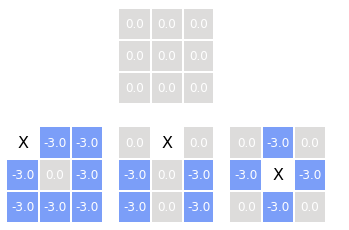

In [147]:
fig, ax = plt.subplots(2, 3, figsize=(6, 4))

clean_square(ax[0, 0])
clean_square(ax[0, 2])

board = Board((0, 0, 0, 0, 0, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[0, 1], scores, board)

board = Board((X, 0, 0, 0, 0, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 0], scores, board)

board = Board((0, X, 0, 0, 0, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 1], scores, board)

board = Board((0, 0, 0, 0, X, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 2], scores, board)

plt.subplots_adjust(wspace=0)

The figure above shows the minimax evaluation for all possible 1st and 2nd moves (ignoring board symmetries), with the expected value of each from the point of view of the current player `X` in the first row and `O` in the second. A score of 0 (gray) indicates an expected draw, while negative scores (blue) indicate an expected loss, with the magnitude indicating how many squares will be unused by the time the game is over (that is higher magnitude corresponds to quicker losses or victories).

We can see that minimax does not distinguish between any of the initial moves for `X` (first row), as it expects every game to end in a draw. However, the number of non-losing moves for `O` (2nd row) varies depending on what `X` played. If `X` played in the corner square, only the center square will lead to a non-losing position according to minimax evaluation. The two other moves provide a larger number of non-losing squares. 

This suggests that different first moves might prove more valuable when `X` is facing a suboptimal `O` player. If `O` plays randomly, the corner move would be more valuable (shown in the next subsection), whereas if `O` has a general bias to play in the center square, `X` might be better of occupying it in the first move. With access to a dataset of games, it should be possible to evaluate the prior probability of either type of bias. This might be improved upon further by opponent modelling which I explore in this essay.

In [151]:
board = Board((X, 0, 0, 0, 0, 0, 0, 0, 0)) 
board.generate_unique_legal_moves()

[Board((1, 2, 0, 0, 0, 0, 0, 0, 0)),
 Board((1, 0, 2, 0, 0, 0, 0, 0, 0)),
 Board((1, 0, 0, 0, 2, 0, 0, 0, 0)),
 Board((1, 0, 0, 0, 0, 2, 0, 0, 0)),
 Board((1, 0, 0, 0, 0, 0, 0, 0, 2))]

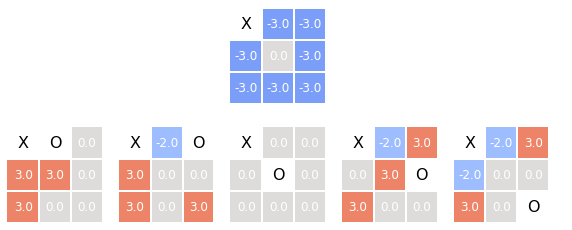

In [157]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))

clean_square(ax[0, 0])
clean_square(ax[0, 1])
clean_square(ax[0, 3])
clean_square(ax[0, 4])

board = Board((X, 0, 0, 0, 0, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[0, 2], scores, board)

board = Board((X, O, 0, 0, 0, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 0], scores, board)

board = Board((X, 0, O, 0, 0, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 1], scores, board)

board = Board((X, 0, 0, 0, O, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 2], scores, board)

board = Board((X, 0, 0, 0, 0, O, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 3], scores, board)

board = Board((X, 0, 0, 0, 0, 0, 0, 0, O)) 
scores = get_scores(board)
plot_board_score(ax[1, 4], scores, board)

plt.subplots_adjust(wspace=0)

The figure above shows the board evaluation for the 2nd and 3rd moves, assuming `X` started in the corner. It is now possible for `X` to blunder in 2 of the 5 unique moves (-2.0 blue squares) as long as `O` does not play the optimal center move (or the suboptimal first move). Switching to the perspective of `O` temporarily, this suggests that playing suboptimally might provide information about `X` (is she a perfect player?) that could be exploited in subsequent games, at the cost of losing one game. More importantly, there might be different positions where more or less information can be gathered for more or less risk. Also the value of this information is higher early in a series of matches against the same opponent.

The two other 2nd and 3rd move evaluations are shown just for completeness, and can be skipped safely.

In [158]:
board = Board((0, X, 0, 0, 0, 0, 0, 0, 0)) 
board.generate_unique_legal_moves()

[Board((2, 1, 0, 0, 0, 0, 0, 0, 0)),
 Board((0, 1, 0, 2, 0, 0, 0, 0, 0)),
 Board((0, 1, 0, 0, 2, 0, 0, 0, 0)),
 Board((0, 1, 0, 0, 0, 0, 2, 0, 0)),
 Board((0, 1, 0, 0, 0, 0, 0, 2, 0))]

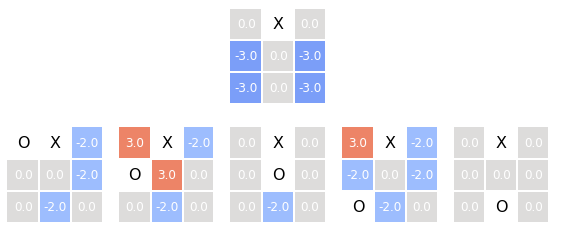

In [160]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))

clean_square(ax[0, 0])
clean_square(ax[0, 1])
clean_square(ax[0, 3])
clean_square(ax[0, 4])

board = Board((0, X, 0, 0, 0, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[0, 2], scores, board)

board = Board((O, X, 0, 0, 0, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 0], scores, board)

board = Board((0, X, 0, O, 0, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 1], scores, board)

board = Board((0, X, 0, 0, O, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 2], scores, board)

board = Board((0, X, 0, 0, 0, 0, O, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 3], scores, board)

board = Board((0, X, 0, 0, 0, 0, 0, O, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 4], scores, board)

plt.subplots_adjust(wspace=0)

In [161]:
board = Board((0, 0, 0, 0, X, 0, 0, 0, 0)) 
board.generate_unique_legal_moves()

[Board((2, 0, 0, 0, 1, 0, 0, 0, 0)), Board((0, 2, 0, 0, 1, 0, 0, 0, 0))]

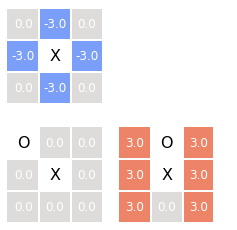

In [162]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4))

clean_square(ax[0, 1])

board = Board((0, 0, 0, 0, X, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[0, 0], scores, board)

board = Board((O, 0, 0, 0, X, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 0], scores, board)

board = Board((0, O, 0, 0, X, 0, 0, 0, 0)) 
scores = get_scores(board)
plot_board_score(ax[1, 1], scores, board)

plt.subplots_adjust(wspace=0)

## Random adversary

## Optimal adversary + bias towards center square (maybe not needed)

## Opponent modelling

This section demonstrates opponent modelling in a tic-tac-toes environment, assuming opponents can be either optimal or random, with a known prior probability. In this section we are interested in inferring not the value of each position but its expected information gain. In the next section we will combine opponent modelling and exploitation.

## Opponent modelling exploitation